In [1]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

#### Below is the PYTHON FILE but I print it here for you 

In [2]:
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings


def ising(N):
    np.random.seed(123)  

    terms = []

    # Generate random coefficients for the transverse field term (X)
    a_coefficients = np.random.random(N)
    for i in range(N):
        term = Term(coefficient=a_coefficients[i], pauli_op="X", qbits=[i])
        terms.append(term)

    # Generate random coefficients for the interaction term (ZZ)
    J_coefficients = np.random.random((N, N))
    for i in range(N):
        for j in range(i):
            if i != j:  # avoid duplicate terms
                term = Term(coefficient=J_coefficients[i, j], pauli_op="ZZ", qbits=[i, j])
                terms.append(term)
    ising = Observable(N, pauli_terms=terms, constant_coeff=0.0)
    return ising


def Molecule_Generator(model):
    if model == "H2":
        r = 0.75
        geometry = [("H", (0, 0, 0)), ("H", (0, 0, r))]
        charge = 0
        spin = 0
        basis = "sto-3g"
    
    elif model == "H4":
        r = 0.85
        geometry = [
            ("H", (0, 0, 0)),
            ("H", (0, 0, 1 * r)),
            ("H", (0, 0, 2 * r)),
            ("H", (0, 0, 3 * r)),
        ]
        charge = 0
        spin = 0
        basis = "sto-3g"
  
    return r, geometry, charge, spin, basis




def circuit_ansatz(nqbits,k, depth, theta_list):
    
    """Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :circuit`
    """
    prog = Program()
    reg = prog.qalloc(nqbits)

    state = binary_repr(k)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]


    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    
    print("This applied state is ", state_pad)

    prog.apply(RY(theta_list[-2]), reg[0])
    prog.apply(RZ(theta_list[-1]), reg[0])

    for d in range(depth):
        
        for i in range(nqbits):
            prog.apply(RY(theta_list[2*i+2*nqbits*d]), reg[i])
            prog.apply(RZ(theta_list[2*i+1+2*nqbits*d]), reg[i])
        
        for i in range(nqbits//2):
            prog.apply(CNOT, reg[2*i+1], reg[2*i])
        
        for i in range(nqbits//2-1):
            prog.apply(CNOT, reg[2*i+2], reg[2*i+1])

    for i in range(nqbits):
        prog.apply(RY(theta_list[2*i+2*nqbits*depth]), reg[i])
        prog.apply(RZ(theta_list[2*i+1+2*nqbits*depth]), reg[i])

    return prog.to_circ()

def opt_funct(circuits, model, qpu, nqbits, energy_lists):
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            total_energy += (i + 1) * energy
        return total_energy

    def callback(x):
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

    return input_funct, callback

"""def get_optimization_func(circuits, H_sp, qpu, nqbits, methods, energy_list):
    def my_func(x):
        energies = []
        for circ in circuits:
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=H_sp))
            energy = result.value
            energies.append(energy)
            energy_list[method].append(energies[i])

        
        for i, method in enumerate(methods):
            energy_list[method].append(energies[i])

        energy_total = sum((i + 1) * energy for i, energy in enumerate(energies))
        return energy_total

    def callback(x):
        my_func(x)

    return my_func, callback"""

'def get_optimization_func(circuits, H_sp, qpu, nqbits, methods, energy_list):\n    def my_func(x):\n        energies = []\n        for circ in circuits:\n            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})\n            result = qpu.submit(bound_circ.to_job(observable=H_sp))\n            energy = result.value\n            energies.append(energy)\n            energy_list[method].append(energies[i])\n\n        \n        for i, method in enumerate(methods):\n            energy_list[method].append(energies[i])\n\n        energy_total = sum((i + 1) * energy for i, energy in enumerate(energies))\n        return energy_total\n\n    def callback(x):\n        my_func(x)\n\n    return my_func, callback'

#### Now is the notebook version that you can practically call it from the python file 

In [3]:
#model = ising(4) 
#print("Transverse Ising Model:", model)

In [4]:
name = Molecule_Generator("H2")

In [5]:
r, geometry, charge, spin, basis = name
(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_elec,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(
    geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True
)
print("Number of electrons = ", n_elec)
nqbits = rdm1.shape[0] * 2
print("Number of qubits before active space selection = ", nqbits)
# print("rdm1", rdm1)
# print(info)
print("Orbital energies = ", orbital_energies)
print("Nuclear repulsion = ", nuclear_repulsion)

Number of electrons =  2
Number of qubits before active space selection =  4
Orbital energies =  [-0.57443656  0.66091005]
Nuclear repulsion =  0.70556961456


/home/huybinh/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [6]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.transforms import transform_to_jw_basis

mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
H = mol_h.get_electronic_hamiltonian()

model = transform_to_jw_basis(H)
print(model)

(-0.10973055606700713+0j) * I^4 +
(0.16821198673715726+0j) * (ZZ|[0, 1]) +
(0.12005143072546025+0j) * (ZZ|[0, 2]) +
(0.16549431486978644+0j) * (ZZ|[1, 2]) +
(0.16549431486978644+0j) * (ZZ|[0, 3]) +
(0.16988452027940376+0j) * (Z|[0]) +
(0.12005143072546025+0j) * (ZZ|[1, 3]) +
(0.16988452027940376+0j) * (Z|[1]) +
(0.04544288414432621+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.04544288414432621+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.04544288414432621+0j) * (YYXX|[0, 1, 2, 3]) +
(0.04544288414432621+0j) * (YXXY|[0, 1, 2, 3]) +
(0.17395378776494128+0j) * (ZZ|[2, 3]) +
(-0.21886306781219628+0j) * (Z|[2]) +
(-0.21886306781219628+0j) * (Z|[3])


In [7]:
print("This model has the number of qubit:", model.nbqbits)
model_matrix_sp = model.get_matrix(sparse=True)
from scipy.sparse.linalg import eigsh
eigval, eigvec = eigsh(model_matrix_sp, k=13)
print(eigval)

This model has the number of qubit: 4
[-1.13711707  0.9014838   0.70556961  0.45980452  0.33373738  0.33373738
 -0.4552414  -0.4552414  -0.5427821  -0.5427821  -0.54171489 -0.54171489
 -0.5427821 ]


In [8]:
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

In [9]:
import numpy as np

nqbits = 4
depth = 4

# Introducing the list of excitations that the user can input 
k_lst = [0, 4, 13, 6]
prog = Program()
init_theta_list = np.random.random(2 * nqbits * (depth + 1) + 2) * 1e-1  # Imported as it is on the SSVQE qulacs
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(len(init_theta_list))]

# Define a function to create and display a circuit
def create_circuit(k):
    return circuit_ansatz(4, k, 4, theta)

# Create and store circuits in a list
circuits_store = [create_circuit(k) for k in k_lst]

# Display the circuits
for circ_dis in circuits_store:
    circ_dis.display()


This applied state is  0000
This applied state is  0100
This applied state is  1101
This applied state is  0110


In [11]:
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"

energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

input_funct, callback = opt_funct(circuits_store, model, qpu, nqbits, energy_lists)
options = {"disp": True, "maxiter": 500, "gtol": 1e-7}

Optimizer = scipy.optimize.minimize(input_funct, x0=init_theta_list, method=method, callback=callback, options=options)

         Current function value: -7.720231
         Iterations: 146
         Function evaluations: 7095
         Gradient evaluations: 165


/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [12]:
print(Optimizer.x)

[ 7.79865027e-01  1.41483016e+00 -1.86336729e-04 -2.21065859e-01
 -9.63933156e-03 -1.30701191e-08 -1.60150191e-02  5.28125317e-08
 -3.15324241e-08 -7.97735192e-01 -3.81021243e-05  3.37235322e-03
 -7.97808681e-01  3.15693107e-05 -5.93870905e-08  2.68768246e-03
  6.30894302e-08  3.48105616e-08  2.21484863e-01  1.96385616e-03
 -1.41513682e+00  8.64086804e-02 -7.87296738e-01 -1.44588779e-09
  6.30291534e-02  1.57079626e+00  2.72597392e-02  1.57588263e-01
  8.98106646e-02  7.87201276e-01  1.77284019e-02  1.76275432e-08
  5.12814888e-02  8.63673636e-02  7.90937070e-01 -4.74293149e-03
 -1.41286931e+00  9.75876033e-03  5.62954400e-08  4.11037597e-02
  1.49706364e-07  3.44479878e-08]


Final energy for k=0000: -0.5417148882984715
Final energy for k=0100: -0.5427820935817849
Final energy for k=1101: -0.5427820987760751
Final energy for k=0110: -1.1161514488103674


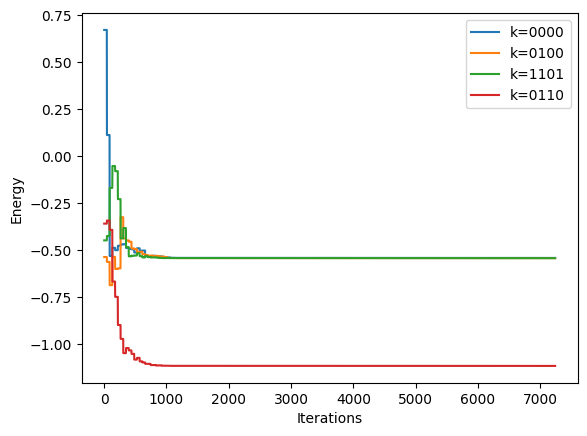

In [16]:
import matplotlib.pyplot as plt
from numpy import binary_repr

all_energy_lists = []

for i in range(len(circuits_store)):
    energy_list = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_list)
    plt.plot(range(len(energy_list)), energy_list, label=f"state={binary_repr(k_lst[i]).zfill(4)}")

    # Print the final energy for each k
    final_energy = energy_list[-1]
    print(f"Final energy for k={binary_repr(k_lst[i]).zfill(4)}: {final_energy}")

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.legend()
plt.show()


One of the nice thing in here is that the ground state the excited states are redefined by the optimizer 
